In [3]:
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import misc
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import pickle
%matplotlib inline

In [4]:
test_img_fnames = os.listdir('data/data/test')
train_img_fnames = os.listdir('data/data/train')
percentage_data_size = 5 / 100
print(len(test_img_fnames), len(train_img_fnames))

2500 22500


# Load in the data
First we need to write a function to load into memory each of the images, and then resize them to (224, 224, 3). scipy.misc.imread and scipy.misc.imresize will be useful for this. You should also rescale the images so that they are on a scale of 0 to 1, meaning each pixel value should be between 0 and 1. This can be achieved by dividing by an appropriate constant.

In [5]:
def load_img(filename):
    img = misc.imread(filename)
    img = misc.imresize(img, (224,224))
    return img / 255

In [4]:
test_imgs = [load_img(os.path.join('data/test', fname)) for fname in test_img_fnames[:int(len(test_img_fnames) * percentage_data_size)]]
test_imgs = np.stack(test_imgs)

In [7]:
train_imgs = [load_img(os.path.join('data/data/train', fname)) for fname in train_img_fnames[:int(len(train_img_fnames) * percentage_data_size)]]
train_imgs = np.stack(train_imgs)

In [8]:
with open('data/train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)

# Load Pretrained VGG network
Now in order to generate the CNN featurizations of our images we need to load a pretrained network. Note that running this network will take a long time on CPU so you can feel free to skip this section and just load the featurizations I provided in the next section

In [ ]:
VGG16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [ ]:
VGG16.summary()

In [ ]:
featurized_training_data = VGG16.predict(train_imgs, verbose=1)

In [ ]:
featurized_test_data = VGG16.predict(test_imgs, verbose=1)

In [10]:
# Save featurizations, I changed filenames so as not to overwrite the original
import pickle
with open('featurized_train_imgs_gen.pkl', 'wb') as f:
    pickle.dump(featurized_training_data, f)
with open('featurized_test_imgs_gen.pkl', 'wb') as f:
    pickle.dump(featurized_test_data, f)

NameError: name 'featurized_training_data' is not defined

# Load featurizations

In [11]:
import pickle
with open('featurized_train_imgs.pkl', 'rb') as f:
    featurized_training_data = pickle.load(f)
with open('featurized_test_imgs.pkl', 'rb') as f:
    featurized_test_data = pickle.load(f)

# Create you network
Now we need to create a network to take in the featurizations and output a label of dog or not dog. To do this you should use Keras' Sequential model. We will need to flatten our (7,7,512) feature input into a vector (HINT: lookup flatten in keras documentation) and then add a Dense layer with some number of neurons (play around with the number of neurons to improve your performance). Then finally we need a Dense layer with 1 neuron and a sigmoid activation to represent our label output. You might want to use more or less model.add calls than have been provided

In [12]:
model = Sequential()
model.add(keras.layers.Flatten(input_shape=(7,7,512)))
model.add(keras.layers.Dense(60, activation="tanh"))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                1505340   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                610       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,505,961
Trainable params: 1,505,961
Non-trainable params: 0
_________________________________________________________________


# Now we need to train the network
You need to compile the model first, and then use the fit function. You should use binary crossentropy as your loss.

In [15]:
model.compile(optimizer="sgd", loss="binary_crossentropy")

In [16]:
model.fit(featurized_training_data, train_labels, epochs=15)

Epoch 1/15
10000/10000 [==============================] - 10s - loss: 0.5887    
Epoch 2/15
10000/10000 [==============================] - 9s - loss: 0.3964     
Epoch 3/15
10000/10000 [==============================] - 9s - loss: 0.3149     
Epoch 4/15
10000/10000 [==============================] - 8s - loss: 0.2818     
Epoch 5/15
10000/10000 [==============================] - 8s - loss: 0.2707     
Epoch 6/15
10000/10000 [==============================] - 8s - loss: 0.2409     
Epoch 7/15
10000/10000 [==============================] - 8s - loss: 0.2199     
Epoch 8/15
10000/10000 [==============================] - 8s - loss: 0.2114     
Epoch 9/15
10000/10000 [==============================] - 8s - loss: 0.2017     
Epoch 10/15
10000/10000 [==============================] - 8s - loss: 0.1980     
Epoch 11/15
10000/10000 [==============================] - 8s - loss: 0.1802     
Epoch 12/15
10000/10000 [==============================] - 8s - loss: 0.1770     
Epoch 13/15
10000/10000 [

Now we need to predict labels for the test set and output it to file. Use keras predict for this. Remember that the predictions are real values between 0 and 1 and you should be outputting just 0 or 1, not a value between.

In [85]:
predictions = model.predict(featurized_test_data)

In [86]:
i = '4_dev'
with open('test_labels_%s.txt' % i, 'w') as f:
    f.write("Id,Label\n")
    for i, val in enumerate(predictions):
        prediction = 0 if val < .5 else 1
        f.write(str(i))
        f.write(',')
        f.write(str(prediction))
        f.write('\n')

In [91]:
# Add disagreeing images manually here. cats are 1, dogs are 0 
known_dic = {0:0, 16:1, 23:1, 59:1, 79:1, 85:0, 89:1, 93:0, 107:1, 116:1, 132:1, 154:0, 322:0,
            279:1, 271:1, 215:0, 202:1, 195:0, 174:0, 154:0, 335:1, 366:1, 350:1, 351:1, 524:0, 525:1, 1065:1, 1069:1,
            913:0, 923:1,2313:1, 2319:0, 2321:1, 2496: 0, 2461:0}
def compare_files(f1, f2):
    f1 = open(f1,'r')
    f2 = open(f2,'r')
    f1.readline()
    f2.readline()
    count, netdif, unknowns, wrong, both_wrong = 0, 0, 0, 0, 0
    for line_num in range(2500):
        mod_1 = f1.readline()
        pred_1 = int(mod_1[mod_1.index(",")+1:][:-1])
        mod_2 = f2.readline()
        pred_2 = int(mod_2[mod_2.index(",")+1:][:-1])
        if pred_2 != pred_1:
            netdif += 1
            if line_num in known_dic:
                if known_dic[line_num] == pred_1:
                    count += 1
                else:
                    count -= 1
                    print(line_num)
                    wrong += 1
            else:
                print("Disagreement on %s , with unknown result" % line_num)
                unknowns += 1
        else:
            if line_num in known_dic and known_dic[line_num] != mod_2: both_wrong += 1; 
                
    print("model 1 scored " + str(count) + " more than model 2")
    print("Net number of different lines is " + str(netdif))
    print("model 1 had %s wrong lines" % str(wrong))
    print("on top of that, both models had %s wrong" % both_wrong)
    print("Number of unknown lines is " + str(unknowns))
compare_files('test_labels_2.txt','test_labels_1.txt')
        

85
93
154
174
195
215
Disagreement on 296 , with unknown result
322
Disagreement on 378 , with unknown result
Disagreement on 397 , with unknown result
Disagreement on 418 , with unknown result
Disagreement on 438 , with unknown result
Disagreement on 452 , with unknown result
Disagreement on 494 , with unknown result
524
Disagreement on 544 , with unknown result
Disagreement on 564 , with unknown result
Disagreement on 575 , with unknown result
Disagreement on 597 , with unknown result
Disagreement on 604 , with unknown result
Disagreement on 610 , with unknown result
Disagreement on 624 , with unknown result
Disagreement on 641 , with unknown result
Disagreement on 715 , with unknown result
Disagreement on 719 , with unknown result
Disagreement on 726 , with unknown result
Disagreement on 740 , with unknown result
Disagreement on 749 , with unknown result
Disagreement on 750 , with unknown result
Disagreement on 761 , with unknown result
Disagreement on 766 , with unknown result
Disa

# Part 2

In [17]:
from sklearn.decomposition import PCA

Now we want to run PCA on our images and our featurizations to see the difference. To save time we will just run it on the first 500 images. Take the first 500 images and 500 featurizations and reshape them into shape (500, x).

In [31]:
original_imgs = np.reshape(train_imgs[:500], (500, 224*224*3))
featurized = np.reshape(featurized_training_data[:500], (500, 7*7*512))

Run PCA with 2 components on the original images

In [34]:
pca_orig = PCA(n_components=2)
pca_orig.fit(original_imgs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Run PCA with 2 components on the featurizations

In [35]:
pca_featurized = PCA(n_components=2)
pca_featurized = pca_featurized.fit(featurized)

Project the original images and featurizations onto the 2 principal components. (HINT: look at the PCA.transform function)

In [36]:
projected_orig_imgs = pca_orig.transform(original_imgs)
projected_featurized = pca_featurized.transform(featurized)

Find the indices of the labels that are cats and the indices that are dogs. np.where will make this very easy

In [45]:
labels = train_labels[:500]
cat_inds = np.where(labels == 1)
dog_inds = np.where(labels == 0)

Plot the PCA of the original images and the PCA of the featurization

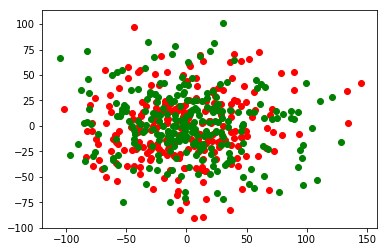

In [46]:
plt.scatter(projected_orig_imgs[cat_inds ,0], projected_orig_imgs[cat_inds, 1], c='red')
plt.scatter(projected_orig_imgs[dog_inds, 0], projected_orig_imgs[dog_inds, 1], c='green')

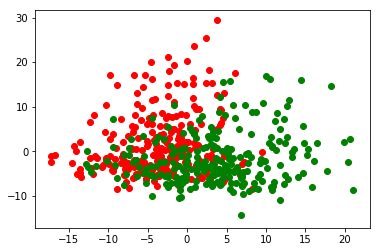

In [47]:
plt.scatter(projected_featurized[cat_inds ,0], projected_featurized[cat_inds, 1], c='red')
plt.scatter(projected_featurized[dog_inds, 0], projected_featurized[dog_inds, 1], c='green')

Question 1: Describe the dierences you see between the two plots in terms
of the clustering of the classes?

The partition between the two clusters is more defined. In the projected featurized, the green dots are clearly to the bottom and right, the red dots are clearly to the top and left. Whereas in the projected original, there is no clear clustering betw

Question 2: Based on your answer to Question 1, desccribe why it is useful
to featurize with a CNN before training a fully connnected model to classify
the images.